# Import

In [31]:
import requests
import sqlite3
import pandas as pd
import os
import json
import requests
import secrets
import matplotlib as mpl
import matplotlib.pyplot as plt
from mal import Anime

# API Authentication

## Helper

In [15]:
CLIENT_ID = '234ccc92400a65d36ada11e16ddced3e'


# 1. Generate a new Code Verifier / Code Challenge.
def get_new_code_verifier() -> str:
    token = secrets.token_urlsafe(100)
    return token[:128]


# 2. Print the URL needed to authorise your application.
def print_new_authorisation_url(code_challenge: str):
    global CLIENT_ID

    url = f'https://myanimelist.net/v1/oauth2/authorize?response_type=code&client_id={CLIENT_ID}&code_challenge={code_challenge}'
    print(f'Authorise your application by clicking here: {url}\n')


# 3. Once you've authorised your application, you will be redirected to the webpage you've
#    specified in the API panel. The URL will contain a parameter named "code" (the Authorisation
#    Code). You need to feed that code to the application.
def generate_new_token(authorisation_code: str, code_verifier: str) -> dict:
    global CLIENT_ID

    url = 'https://myanimelist.net/v1/oauth2/token'
    data = {
        'client_id': CLIENT_ID,
        'code': authorisation_code,
        'code_verifier': code_verifier,
        'grant_type': 'authorization_code'
    }

    response = requests.post(url, data)
    response.raise_for_status()  # Check whether the requests contains errors

    token = response.json()
    response.close()
    print('Token generated successfully!')

    with open('token.json', 'w') as file:
        json.dump(token, file, indent = 4)
        print('Token saved in "token.json"')

    return token


def generate_refresh_token(authorisation_code: str, code_verifier: str) -> dict:
    global CLIENT_ID

    url = 'https://myanimelist.net/v1/oauth2/token'
    data = {
        'client_id': CLIENT_ID,
        'code': authorisation_code,
        'code_verifier': token,
        'grant_type': 'authorization_code'
    }

    response = requests.post(url, data)
    response.raise_for_status()  # Check whether the requests contains errors

    token = response.json()
    response.close()
    print('Token generated successfully!')

    with open('token.json', 'w') as file:
        json.dump(token, file, indent = 4)
        print('Token saved in "token.json"')

    return token


# 4. Test the API by requesting your profile information
def print_user_info(access_token: str):
    url = 'https://api.myanimelist.net/v2/users/@me'
    response = requests.get(url, headers = {
        'Authorization': f'Bearer {access_token}'
        })
    
    response.raise_for_status()
    user = response.json()
    response.close()

    print(f"\n>>> Greetings {user['name']}! <<<")

Authorise your application by clicking here: https://myanimelist.net/v1/oauth2/authorize?response_type=code&client_id=234ccc92400a65d36ada11e16ddced3e&code_challenge=EPxSJ1VgMn0AUZFhUGLaEUf-zHbqUcVfiwpuKeOHjQZV--wEm30ZFr3paUYAmVoZxJivLr500XNL31MwL0opYo7D8lh5Hd30Hkt4EUe5CF8Bznvs1GvoICTtNCXQ81Sw



KeyboardInterrupt: Interrupted by user

## Generate Token

In [ ]:
code_verifier = code_challenge = get_new_code_verifier()
print_new_authorisation_url(code_challenge)

authorisation_code = input('Copy-paste the Authorisation Code: ').strip()
token = generate_new_token(authorisation_code, code_verifier)

print_user_info(token['access_token'])

## Load Token

In [23]:
with open('token.json') as f:
    token = json.load(f)

# Try accessing data

In [29]:
N = 100
TOP_ANIME_API = 'https://api.myanimelist.net/v2/anime/ranking?ranking_type=all&limit={:d}'.format(N)

columns = ['id', 'title', 'genres', 'mean', 'nsfw', 'popularity', 
           'status', 'num_list_users', 'related_anime','rating', 
           'media_type', 'synopsis', 'statistics']
get_anime = lambda id_: f'https://api.myanimelist.net/v2/anime/{id_}?fields={",".join(columns)}'


access_token = token['access_token']
r = requests.get(TOP_ANIME_API, headers = {
        'Authorization': f'Bearer {access_token}'})

print('status:', r.status_code)
data_json = r.json()['data']
# print(data_json)


ids = []
ranks = []
titles = []

for anime in data_json:
    anime_id = anime['node']['id']; 
    rank = anime['ranking']['rank'];
    title = anime['node']['title'];
    ids.append(anime_id)
    ranks.append(rank)
    titles.append(title.strip())
         
    
rank_df = pd.DataFrame({'id': ids, 'rank':ranks, 'title':titles})
print('rank table')
print(rank_df.head())


anime_df = pd.DataFrame()
for id_ in ids:
    r = requests.get(get_anime(id_), headers = {
        'Authorization': f'Bearer {access_token}'})
    if r.status_code == 200:
        anime_df = anime_df.append(r.json(), ignore_index = True)
    else:
        print('id:', id_, ' not found')
anime_df = anime_df[columns]

anime_df['genres'] = anime_df['genres'].map(lambda ls: [l['name'] for l in ls])

anime_df['related_anime'] = anime_df['related_anime'].map(lambda ls: [l['node']['id'] for l in ls])
anime_df['watching'] = anime_df['statistics'].map(lambda x: x['status']['watching'])
anime_df['completed'] = anime_df['statistics'].map(lambda x: x['status']['completed'])
anime_df['onhold'] = anime_df['statistics'].map(lambda x: x['status']['on_hold'])
anime_df['dropped'] = anime_df['statistics'].map(lambda x: x['status']['dropped'])
anime_df['plan_to_watch'] = anime_df['statistics'].map(lambda x: x['status']['plan_to_watch'])
anime_df = anime_df.drop('statistics', axis = 1)

print('anime table')
print(anime_df.head())

status: 200
rank table
      id  rank                                        title
0   5114     1             Fullmetal Alchemist: Brotherhood
1  48583     2  Shingeki no Kyojin: The Final Season Part 2
2   9253     3                                  Steins;Gate
3  28977     4                                     Gintama°
4  38524     5           Shingeki no Kyojin Season 3 Part 2
anime table
        id                                        title  \
0   5114.0             Fullmetal Alchemist: Brotherhood   
1  48583.0  Shingeki no Kyojin: The Final Season Part 2   
2   9253.0                                  Steins;Gate   
3  28977.0                                     Gintama°   
4  38524.0           Shingeki no Kyojin Season 3 Part 2   

                                              genres  mean   nsfw  popularity  \
0  [Action, Adventure, Comedy, Drama, Fantasy, Mi...  9.15  white         3.0   
1  [Action, Drama, Fantasy, Military, Mystery, Sh...  9.15  white       220.0   
2      

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

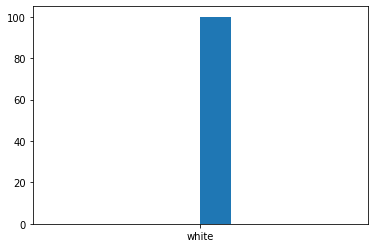